In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd

In [3]:
import os
import keras
import matplotlib.pyplot as plt
from glob import glob 
from keras.models import Sequential 
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D,Input,SeparableConv2D
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
import cv2
from PIL import Image
from pathlib import Path
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,confusion_matrix,classification_report

Using TensorFlow backend.


In [4]:
mainDIR = os.listdir('C:/Users/My HP Pavilion/Desktop/data sets/data-project')
print(mainDIR)

['test', 'train', 'val']


In [6]:
path_train = 'C:/Users/My HP Pavilion/Desktop/data sets/data-project/train'
path_test  =  'C:/Users/My HP Pavilion/Desktop/data sets/data-project/test'
path_val   =    'C:/Users/My HP Pavilion/Desktop/data sets/data-project/val'

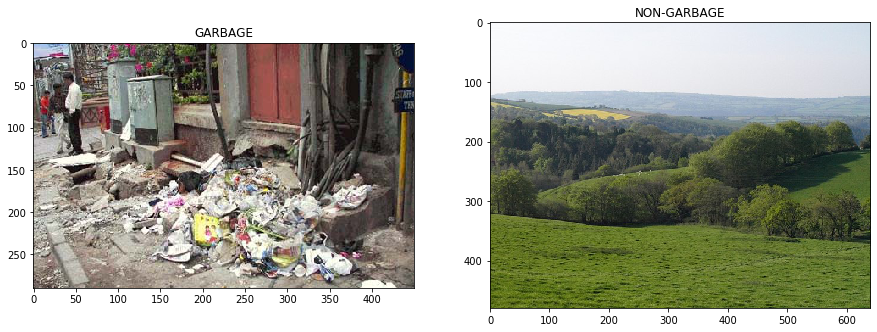

In [13]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
img = glob(path_train+"/garbage/*.jpg") #Getting an image in the PNEUMONIA folder
img = np.asarray(plt.imread(img[2]))
plt.title('GARBAGE')
plt.imshow(img)

plt.subplot(1 , 2 , 2)
img = glob(path_train+"/non-garbage/*.jpg") #Getting an image in the NORMAL folder
img = np.asarray(plt.imread(img[3]))
plt.title('NON-GARBAGE')
plt.imshow(img)

plt.show()

In [20]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

train_batch = train_datagen.flow_from_directory('C:/Users/My HP Pavilion/Desktop/data sets/data-project/train',
                                                 target_size = (300, 300),
                                                classes = ["garbage", "non-garbage"],
                                                 class_mode = 'categorical')

val_batch = test_datagen.flow_from_directory('C:/Users/My HP Pavilion/Desktop/data sets/data-project/val',
    target_size=(300, 300),
    classes = ["garbage", "non-garbage"],
    class_mode = 'categorical')                                         
  

test_batch = test_datagen.flow_from_directory('C:/Users/My HP Pavilion/Desktop/data sets/data-project/test',
                                            target_size = (300, 300),
                                            classes = ["garbage", "non-garbage"],
                                            class_mode = 'categorical')

Found 54 images belonging to 2 classes.
Found 11 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [21]:
def build_model():
    input_img = Input(shape=train_batch.image_shape, name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    return model

In [22]:
#Function for getting accuracy and loss plots
def create_plots(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [23]:
model= build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 150, 150, 128)     8896      
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 150, 150, 128)     17664     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 128)       0         
__________

In [ ]:
batch_size = 16
epochs = 10
early_stop = EarlyStopping(patience=25,
                           verbose = 2,
                           monitor='val_loss',
                           mode='auto')

checkpoint = ModelCheckpoint(
    filepath='best_model',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    verbose = 1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=1, 
    min_lr=0.0001
)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=0.0001))

history = model.fit_generator(epochs=epochs,
                              callbacks=[early_stop,checkpoint,reduce],
                              shuffle=True,
                              validation_data=val_batch,
                              generator=train_batch,
                              steps_per_epoch=50,
                              validation_steps=10,
                              verbose=2)

Epoch 1/10
